In [2]:
import os
import torch
import torchvision
import tarfile
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data_dir = '../input/chest-xray-pneumonia/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'val', '__MACOSX', 'train', 'chest_xray']
['NORMAL', 'PNEUMONIA']


In [5]:
pneumonia_images = os.listdir(data_dir + "/train/PNEUMONIA")
print(len(pneumonia_images))
normal_images = os.listdir(data_dir + "/train/NORMAL")
print(len(normal_images))

3875
1341


In [32]:
train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])


val_tfms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


test_tfms = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_ds = ImageFolder(data_dir+'/train', transform=train_tfms)
val_ds   = ImageFolder(data_dir+'/val', transform=val_tfms)
test_ds  = ImageFolder(data_dir+'/test', transform=test_tfms)

img, label = train_ds[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-2.1179, -2.1179, -0.8678,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -0.8849, -0.7993,  ..., -0.3541, -0.3198, -2.1179],
         [-2.1179, -0.9192, -0.8164,  ..., -0.3027, -0.2856, -0.2684],
         ...,
         [ 1.0159,  0.8618,  0.9132,  ..., -1.8439, -1.8268, -2.1179],
         [-2.1179,  1.2214,  1.1015,  ..., -1.8439, -1.8097, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -1.8268, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -0.7577,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -0.7752, -0.6877,  ..., -0.2325, -0.1975, -2.0357],
         [-2.0357, -0.8102, -0.7052,  ..., -0.1800, -0.1625, -0.1450],
         ...,
         [ 1.1681,  1.0105,  1.0630,  ..., -1.7556, -1.7381, -2.0357],
         [-2.0357,  1.3782,  1.2556,  ..., -1.7556, -1.7206, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -1.7381, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -0.5321,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -0.5495, -0.4624,  ..., -0

In [33]:
print(train_ds.classes)

['NORMAL', 'PNEUMONIA']


In [34]:
batch_size = 64

In [35]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [36]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

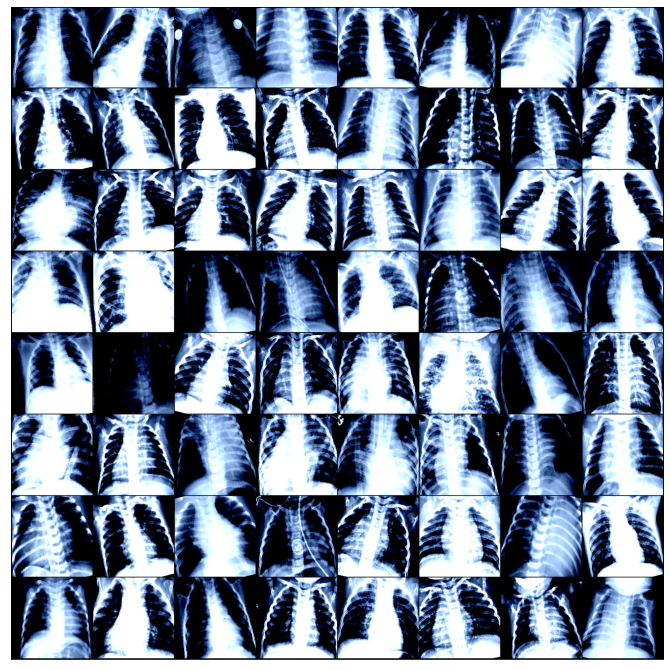

In [37]:
show_batch(train_dl)

In [38]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [41]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [43]:
class x_ray(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)

        for param in self.network.parameters():
            param.requires_grad = False
        
        n_inputs = self.network.classifier[6].in_features
        self.network.classifier[6] = nn.Sequential(nn.Linear(n_inputs, 2))
        
    def forward(self, xb):
        return self.network(xb)

In [45]:
model = x_ray()
model

x_ray(
  (network): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): 

In [46]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [47]:
model = to_device(x_ray(), device)

In [48]:
# Initial Performance
evaluate(model, valid_dl)

{'val_loss': 0.7006522417068481, 'val_acc': 0.5}

In [57]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

In [59]:
history = fit(num_epochs, 0.1*lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 0.2204, val_loss: 0.2650, val_acc: 0.8750
Epoch [1], train_loss: 0.2109, val_loss: 0.2562, val_acc: 0.9375
Epoch [2], train_loss: 0.2056, val_loss: 0.2351, val_acc: 0.9375
Epoch [3], train_loss: 0.2140, val_loss: 0.2326, val_acc: 0.9375
Epoch [4], train_loss: 0.2133, val_loss: 0.2303, val_acc: 0.9375


In [60]:
evaluate(model, valid_dl)

{'val_loss': 0.23025992512702942, 'val_acc': 0.9375}

In [61]:
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_loss': 0.4734327793121338, 'val_acc': 0.8260416984558105}

In [62]:
torch.save(model, 'x_ray_best.pt')

In [63]:
from PIL import Image
import cv2
def predict_image(image):
    image_tensor = test_tfms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

Result: Pneumonia
Actual: Pneumonia


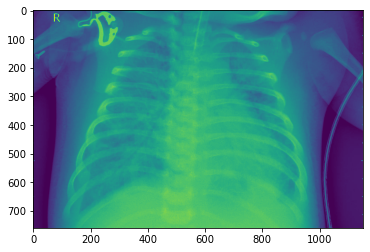

In [66]:
test =  cv2.imread('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg',0)
res = predict_image(Image.fromarray(cv2.cvtColor(test,cv2.COLOR_GRAY2RGB)))

plt.imshow(test)
if res == 0:
    diagonosis = 'Normal'
else:
    diagnosis = 'Pneumonia'
print(f"Result: {diagnosis}")
print(f"Actual: Pneumonia")

0
Result: Normal
Actual: Normal


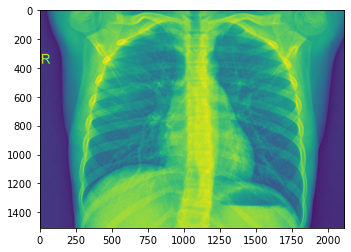

In [74]:
test =  cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0003-0001.jpeg',0)
res = predict_image(Image.fromarray(cv2.cvtColor(test,cv2.COLOR_GRAY2RGB)))
# print(res)
plt.imshow(test)
if res == 0:
    diagnosis = 'Normal'
else:
    diagnosis = 'Pneumonia'
print(f"Result: {diagnosis}")
print(f"Actual: Normal")

Result: Pneumonia
Actual: Normal


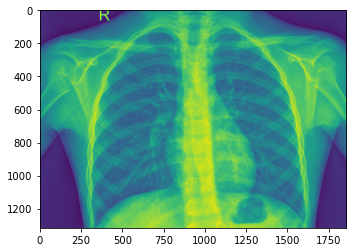

In [76]:
test =  cv2.imread('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg',0)
res = predict_image(Image.fromarray(cv2.cvtColor(test,cv2.COLOR_GRAY2RGB)))
# print(res)
plt.imshow(test)
if res == 0:
    diagnosis = 'Normal'
else:
    diagnosis = 'Pneumonia'
print(f"Result: {diagnosis}")
print(f"Actual: Normal")